<a href="https://colab.research.google.com/github/greatsong/fingerspelling/blob/main/%EC%A7%80%EB%AC%B8%EC%9E%90_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_%EC%A4%80%EB%B9%84_%EC%A4%91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install hgtk
!pip install gtts

In [37]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = 224 //video.videoWidth;
      canvas.height = 224 //video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename, image

try:
  for i in range(3) :
    filename,image = take_photo(f'photo{i}.jpg')
    print('Saved to {}'.format(filename))
    # Show the image which was just taken.
    display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

KeyboardInterrupt: ignored

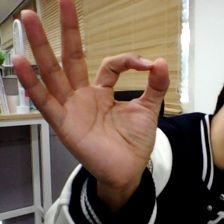

1/1 [==============================] - 1s 1s/step
Class: ㄴ
Confidence Score: 57 %


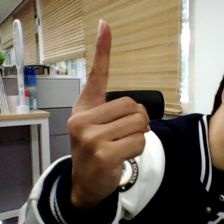

1/1 [==============================] - 0s 38ms/step
Class: ㄱ
Confidence Score: 72 %


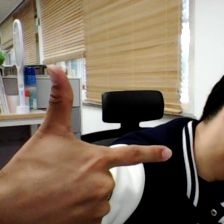

1/1 [==============================] - 0s 40ms/step
Class: ㄱ
Confidence Score: 97 %


In [36]:
import tensorflow
from keras.models import load_model  # TensorFlow is required for Keras to work
import cv2  # Install opencv-python
import numpy as np
from google.colab.patches import cv2_imshow
# Disable scientific notation for clarity
np.set_printoptions(suppress=True)
# Load the model
model = load_model("keras_model.h5", compile=False)
# Load the labels
class_names = open("labels.txt", "r").readlines()
result = []
for i in range(3) :
    # Show the image in a window
    path = f'photo{i}.jpg'
    image = cv2.imread(path,cv2.IMREAD_COLOR)
    cv2_imshow(image)
    # Make the image a numpy array and reshape it to the models input shape.
    image = np.asarray(image, dtype=np.float32).reshape(1, 224, 224, 3)
    # Normalize the image array
    image = (image / 127.5) - 1
    # Predicts the model
    prediction = model.predict(image)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence_score = prediction[0][index]
    # Print prediction and confidence score
    print("Class:", class_name[2:], end="")
    print("Confidence Score:", str(np.round(confidence_score * 100))[:-2], "%")
    result.append(class_name[2:])
    # Listen to the keyboard for presses.
    keyboard_input = cv2.waitKey(1)

    # 27 is the ASCII for the esc key on your keyboard.
    if keyboard_input == 27:
        break

#camera.release()
cv2.destroyAllWindows()

In [34]:
import hgtk
result = hgtk.letter.compose(result[0],result[1],result[2])

NotHangulException: ignored

In [ ]:
from gtts import gTTS
from IPython.display import Audio
tts = gTTS(text=result, lang='ko')
tts.save('result.mp3')
sound_file = 'result.mp3'
Audio(sound_file, autoplay=True)